## Comparison of yield strength prediction perfomance between different ML models (GBR, RF, SVR, KNN) with Domain knowledge based features as elememtal properties 


In [1]:
import pandas as pd 
import numpy as np
from cbfv.composition import generate_features
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
rng_seed = 20

### Reading .csv train and test data and storing in dataframe

In [2]:
df_train = pd.read_csv('data/model_input/train_yieldstrength.csv')
df_test = pd.read_csv('data/model_input/test_yieldstrength.csv')
print('size of train data', len(df_train))
print('size of test data',len(df_test))


size of train data 115
size of test data 25


In [3]:
df_train.head()
df_test.head()


,formula,T,target
0,Nb92.0Hf5.4Ti2.0Zr0.5,24,347.51
1,Nb92.0Hf5.4Ti2.0Zr0.5,1093,126.87
2,Nb92.0Hf5.4Ti2.0Zr0.5,1371,71.02
3,Nb92.0Hf5.4Ti2.0Zr0.5,1482,59.30
4,Nb92.0Hf5.4Ti2.0Zr0.5,1649,28.96


### Featurization using CBFV 

In [4]:
# FEATURIZATION 
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train,elem_prop='oliynyk',drop_duplicates=False,extend_features=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test,elem_prop='oliynyk',drop_duplicates=False,extend_features=True)


Processing Input Data: 100%|████████████████| 115/115 [00:00<00:00, 9136.36it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████| 115/115 [00:00<00:00, 3211.84it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████████████| 25/25 [00:00<00:00, 8137.96it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████████████| 25/25 [00:00<00:00, 6070.61it/s]


	Creating Pandas Objects...


### Scaling using standard scaler 

In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

### Machine Learning Models Performance Evaluation Helper Functions 

In [6]:

################# EVALUATION MATRIX #######################################
def model_evaluation(y_actual,y_predict, label = None,model='None'):
    df = pd.DataFrame([{'mae':mean_absolute_error(y_actual,y_predict),
                        'rmse':mean_squared_error(y_actual,y_predict,squared=False),
                        'r2score':r2_score(y_actual,y_predict),
                        'model':model
                        }])
    if label:
        df.index = [label]
        
    return df

def model_evaluation_result(y_Train,y_train_predict,y_Test,y_test_predict,model='None'):
    result = pd.concat([model_evaluation(y_Train,y_train_predict,'Train',model),
                    model_evaluation(y_Test,y_test_predict, 'Test',model)])
    return result


def plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train,y_train_predict, s=160,alpha=0.7, label='Training Data ($r^2$ ={0:.3f})'.format(r2_train))
    plt.scatter(y_test,y_test_predict,s=160, alpha=0.7, label='Test Data ($r^2$ ={0:.3f})'.format(r2_test))
    # plt.plot(y_test,y_test,'--',dashes=(5, 6),linewidth=2,c='grey',label = 'Ideal Fit')
    plt.axline((0, 0), (1000, 1000), linewidth=2, color='k',linestyle='dashed',label='ideal fit')
    plt.xlabel('Actual Yield Strength (MPa) ', size=16)
    plt.ylabel('Predicted ield Strength (MPa)',size=16)
    plt.tick_params(labelsize=14)
    plt.xlim((0,1050))
    plt.ylim((0,1050))
    plt.legend(prop={'size': 14})
    plt.minorticks_on()
    plt.tick_params(labelsize=16)
    plt.tick_params(direction='in',which='major', length=15, bottom=True, top=True, left=True, right=True,colors='k')
    plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True,colors='k')


### Gradient Boost Regressor with grid search group kfold

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingRegressor(random_state=rng_seed, criterion='mse')


param_grid = { 'n_estimators' : [50,100,200],
                'max_depth': [3],
                'max_features': ['auto', 'sqrt', 'log2'],
                'min_samples_split': [5,6,7],
                'min_samples_leaf':[4,5,6],
             }

# Instantiate GroupKfold with no of splits = 5
gkf=GroupKFold(n_splits=5)


gbr_gs= GridSearchCV(
                     base_model,
                     param_grid,
                     scoring='neg_mean_squared_error',
                     cv=gkf
                    )

# Fit training Data 
gbr_gs.fit(X_train,y_train,groups=formulae_train)

# Best Estimator
print(gbr_gs.best_estimator_)

gbr_gs_best=gbr_gs.best_estimator_


gbr_gs_best.fit(X_train,y_train)

# predict y_train and y_test
y_train_predict=gbr_gs_best.predict(X_train)
y_test_predict=gbr_gs_best.predict(X_test)

r2_train = r2_score(y_train,y_train_predict)
r2_test = r2_score(y_test,y_test_predict)
#print(gbr_gs_best)

print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))


GradientBoostingRegressor(criterion='mse', max_features='sqrt',
                          min_samples_leaf=4, min_samples_split=5,
                          n_estimators=200, random_state=20)
r2score_train: 0.9837371784658941
r2score_test: 0.5998419079510953


### Performance Evaluation Gradient Boost Regressor

             mae        rmse   r2score   model
Train  13.632421   18.630595  0.983737  gbr_GS
Test   95.247882  141.361906  0.599842  gbr_GS
****************************************************************************
                                     feature_name  importance
132                                             T    0.748907
13                           avg_Zunger_radii_sum    0.017773
10                              avg_Atomic_Radius    0.016218
74   range_Number_of_unfilled_d_valence_electrons    0.015199
70                                range_valence_d    0.013011
128            var_heat_of_vaporization_(kJ/mol)_    0.012935
30     avg_Number_of_unfilled_d_valence_electrons    0.012205
83                 range_heat_of_fusion_(kJ/mol)_    0.011169
28     avg_Number_of_unfilled_s_valence_electrons    0.009730
118    var_Number_of_unfilled_d_valence_electrons    0.009151


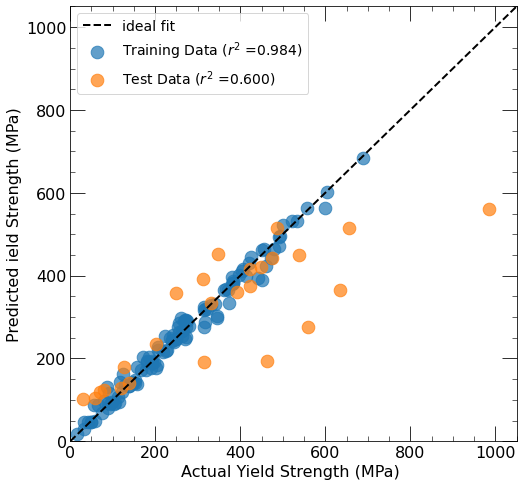

In [8]:
############## EVALUATION ##########################################################

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,'gbr_GS'))
print('****************************************************************************')
feature_imp_df = pd.concat([pd.Series(X_train_unscaled.columns),
                            pd.Series(gbr_gs_best.feature_importances_)], 
                           axis = 1)
feature_imp_df.columns=['feature_name','importance'];
print(feature_imp_df.sort_values('importance',ascending=False)[0:10])
feature_imp_df.index = feature_imp_df.feature_name

#feature_imp_df.sort_values('importance', ascending=False)[0:12].plot(kind="bar", figsize=(16,4))

plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test)

### Random Forest Regressor with grid search group kfold

In [9]:

##### Random forest regressor with Grid search ############################
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
base_model = RandomForestRegressor(random_state=rng_seed, criterion='mse')

param_grid = { 'n_estimators' : [50,100,200,300],
                'max_depth': [3,4,5], 
                'max_features': ['auto','sqrt','log2'],
                'min_samples_split': [3,4,5]}



gkf=GroupKFold(n_splits=5)
rf_gs=GridSearchCV(base_model,param_grid,scoring='neg_mean_squared_error',cv=gkf)
rf_gs.fit(X_train,y_train,groups=formulae_train)
print(rf_gs.best_estimator_)


rf_best = rf_gs.best_estimator_
print(rf_best)


y_train_predict=rf_best.predict(X_train)
y_test_predict=rf_best.predict(X_test)

r2_train = r2_score(y_train,y_train_predict)
r2_test = r2_score(y_test,y_test_predict)

print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))


RandomForestRegressor(max_depth=3, min_samples_split=5, n_estimators=300,
                      random_state=20)
RandomForestRegressor(max_depth=3, min_samples_split=5, n_estimators=300,
                      random_state=20)
r2score_train: 0.8872487139449454
r2score_test: 0.5303797433399423


### Performance Evaluation Random Forest Regressor

              mae        rmse   r2score  model
Train   39.654814   49.055706  0.887249  rf_GS
Test   101.871608  153.140479  0.530380  rf_GS
****************************************************************************
                                     feature_name  importance
132                                             T    0.859732
90                                     var_Period    0.013243
12                            avg_Covalent_Radius    0.010581
16                  avg_Pauling_Electronegativity    0.009751
41            avg_thermal_conductivity_(W/(m_K))_    0.007760
70                                range_valence_d    0.007601
114                                 var_valence_d    0.007386
118    var_Number_of_unfilled_d_valence_electrons    0.007290
74   range_Number_of_unfilled_d_valence_electrons    0.007141
3                                       avg_group    0.006814
20            avg_Allred-Rockow_electronegativity    0.006452
30     avg_Number_of_unfilled_d_valenc

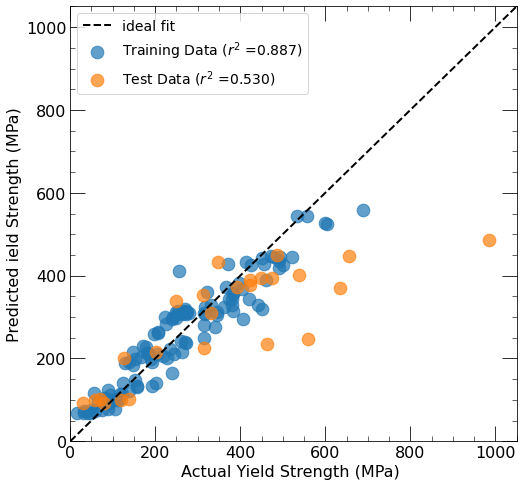

In [10]:
############## EVALUATION ##########################################################
print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,'rf_GS'))
print('****************************************************************************')
feature_imp_df = pd.concat([pd.Series(X_train_unscaled.columns),
                            pd.Series(rf_best.feature_importances_)], 
                           axis = 1)
feature_imp_df.columns=['feature_name','importance'];
print(feature_imp_df.sort_values('importance',ascending=False)[0:20])
feature_imp_df.index = feature_imp_df.feature_name

#feature_imp_df.sort_values('importance', ascending=False)[0:12].plot(kind="bar", figsize=(16,4))

plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test)

### Support Vector Regressor with grid search group kfold

In [11]:
## SVR 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr_params = {
    'C': [1,10,100],
    "kernel":['linear','poly','rbf','sigmoid'],
    "epsilon":[0.001,0.01,0.1,1,10,100]
}

# C is the regularization penalty; 
# low value of C wider margin that is allowing soft margin 
# higher value of C narrow margin that is hard margin 

base_model = SVR(gamma='scale')



gkf=GroupKFold(n_splits=5)
svr_gr=GridSearchCV(base_model,svr_params,scoring='neg_mean_squared_error',cv=gkf)



svr_gr.fit(X_train, y_train,groups=formulae_train)
print(svr_gr.best_params_)
print("MSE:"+ str(-svr_gr.best_score_))

svr_best = svr_gr.best_estimator_
y_train_predict=svr_best.predict(X_train)
y_test_predict=svr_best.predict(X_test)


print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))


{'C': 10, 'epsilon': 100, 'kernel': 'linear'}
MSE:10522.018659603522
r2score_train: 0.7384139786167835
r2score_test: 0.4849475365473578


### Performance Evaluation Support Vector Regressor

              mae        rmse   r2score model
Train   65.405654   74.719858  0.738414   SVR
Test   107.721348  160.377088  0.484948   SVR
****************************************************************************


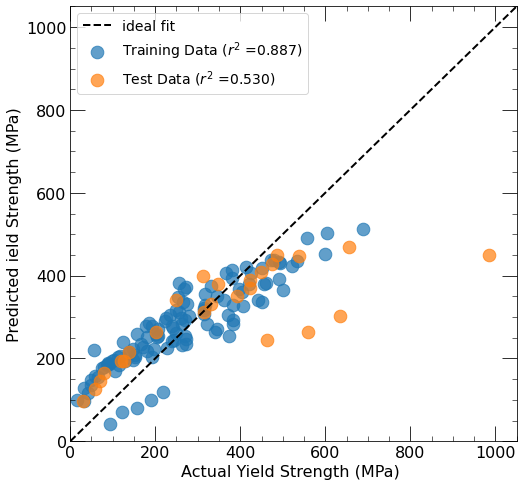

In [12]:
############## EVALUATION ##########################################################

print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,'SVR'))
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test)
print('****************************************************************************')


### KNN Regressor with grid search group kfold

In [13]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
KNN_params = {
    'n_neighbors': np.arange(2,6)
}
base_model = KNeighborsRegressor()

gkf=GroupKFold(n_splits=5)

KNN_gr = GridSearchCV(base_model,KNN_params,scoring='neg_mean_squared_error',cv=gkf)

KNN_gr.fit(X_train, y_train,groups=formulae_train)

print(KNN_gr.best_params_)
#print(KNN_gr.cv_results_)

KNN_best = KNN_gr.best_estimator_

y_train_predict=KNN_best.predict(X_train)
y_test_predict=KNN_best.predict(X_test)

print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))


{'n_neighbors': 3}
r2score_train: 0.8675549463265422
r2score_test: 0.618979481653276


### Performance Evaluation KNN regressor

              mae        rmse   r2score   model
Train   35.008319   53.167550  0.867555  KNN_gs
Test   104.677733  137.940175  0.618979  KNN_gs
****************************************************************************


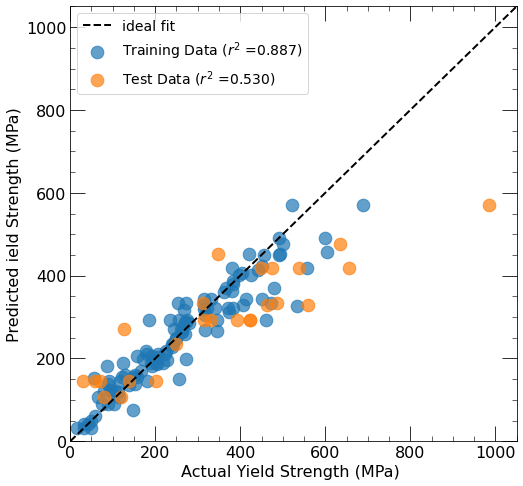

In [14]:
############## EVALUATION ##########################################################


print(model_evaluation_result(y_train,y_train_predict,y_test,y_test_predict,'KNN_gs'))
plot_model_performance(y_train,y_train_predict,y_test,y_test_predict,r2_train,r2_test)
print('****************************************************************************')


### Lasso Regressor

In [15]:
from sklearn.linear_model import Lasso
#lm = LinearRegression()
#lm = LassoCV(alphas = [.1, 10], cv = 10, max_iter=10000)
# lm = Lasso()
lm = Lasso(alpha =1,max_iter=1000000)
lm.fit(X_train,y_train)
y_train_predict=lm.predict(X_train)
y_test_predict=lm.predict(X_test)

print('r2score_train:',r2_score(y_train,y_train_predict))
print('r2score_test:',r2_score(y_test,y_test_predict))



r2score_train: 0.8670927929727154
r2score_test: 0.5123812706107702


### Gausssian Process Regressor

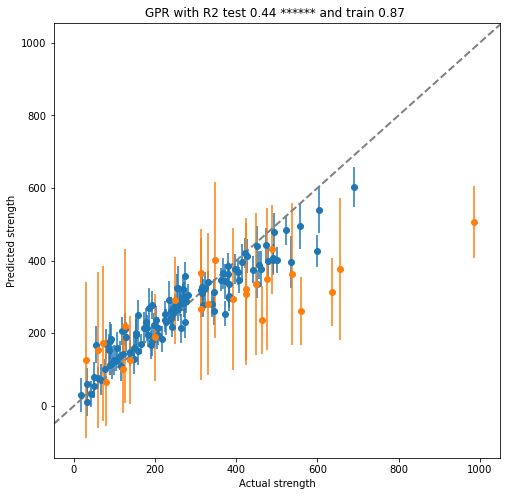

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, RBF

# Gaussian process with Mat??rn kernel as surrogate model


kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * Matern(length_scale=2, nu=2.5) + WhiteKernel(5)


gpr = GaussianProcessRegressor(kernel=kernel, alpha=10000, n_restarts_optimizer=30, normalize_y=False)

#gpr = GaussianProcessRegressor()

gpr.fit(X_train,y_train)
y_pred_tr, y_pred_tr_std =gpr.predict(X_train,return_std=True)
y_pred_te, y_pred_te_std =gpr.predict(X_test,return_std=True)


plt.figure(figsize=(8,8))
plt.errorbar(y_train,y_pred_tr,yerr=y_pred_tr_std,fmt='o')
plt.errorbar(y_test,y_pred_te,yerr=y_pred_te_std,fmt='o')
plt.xlabel('Actual strength')
plt.ylabel('Predicted strength')
plt.title('GPR with R2 test %0.2f ****** and train %0.2f '%(r2_score(y_test,y_pred_te),r2_score(y_train,y_pred_tr)))
plt.axline((0, 0), (1000, 1000), linewidth=2, color='grey',linestyle='dashed')
#np.array(y_train).reshape(-1,1)